# Case Study 5: Missing Data and Imputation Methods

**Jaclyn Coate, Reagan Meagher, Megan Riley**

## 1. Introduction 



In statistics the process of replacing missing data is referred to as imputation. Imputation is often preferred to dropping missing data in real world data analysis scenarios. This is because the ability to successfully impute data allows researchers to salvage datasets in their entirety or at a minimum retaining contributing portions of data that would otherwise need to be discarded.
 
The absence of imputation results in researchers struggling against problems such as having omitted variable biases (due to lost data) and therefore the dataset not being truly representative samples. On the same page any output results would not be statistically accurate or representative of the population. Trying to analyze around missing data can create efficiency issues as well as handling the data overall more difficult (Barnard 1999).
 
As researchers we will move forward in a full exploratory data analysis, in this process we will elevate different types of missing data. The data here falls into the category of missing at random (MAR). This type of missing data drives our methodology of imputation: multiple imputation. After the imputation method has been enacted on data then traditional and standard methods can be used to analyze the data. As we work through this case study we will be examining different imputation techniques to see which performs best on our dataset.


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_squared_error

pd.options.display.float_format = '{:.2f}'.format

In [2]:
data_loc = "https://raw.githubusercontent.com/JaclynCoate/7333_Quantifying_The_World/main/Unit10_CaseStudy5/Data/train%203.csv"
raw_data = pd.read_csv(data_loc)
target = raw_data["price_doc"]
train_raw = raw_data.drop(['price_doc','id','timestamp'], axis = 1) 

In [3]:
train_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30471 entries, 0 to 30470
Columns: 289 entries, full_sq to market_count_5000
dtypes: float64(119), int64(155), object(15)
memory usage: 67.2+ MB


## 2. Data

The data that has been provided for our case study is a housing dataset. The data consists of over 270 columns. In our exploratory data analysis we surfaced 51 numbers of columns containing NAs totaling over 261,000 instances of missing data.

In [4]:
train_raw.describe()

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25_raion,shopping_centers_raion,office_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,...,cafe_count_3000,cafe_sum_3000_min_price_avg,cafe_sum_3000_max_price_avg,cafe_avg_price_3000,cafe_count_3000_na_price,cafe_count_3000_price_500,cafe_count_3000_price_1000,cafe_count_3000_price_1500,cafe_count_3000_price_2500,cafe_count_3000_price_4000,cafe_count_3000_price_high,big_church_count_3000,church_count_3000,mosque_count_3000,leisure_count_3000,sport_count_3000,market_count_3000,green_part_5000,prom_part_5000,office_count_5000,office_sqm_5000,trc_count_5000,trc_sqm_5000,cafe_count_5000,cafe_sum_5000_min_price_avg,cafe_sum_5000_max_price_avg,cafe_avg_price_5000,cafe_count_5000_na_price,cafe_count_5000_price_500,cafe_count_5000_price_1000,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000
count,30471.00,24088.00,30304.00,20899.00,20899.00,16866.00,20899.00,20899.00,16912.00,30471.00,30471.00,30471.00,30471.00,30471.00,23783.00,30471.00,30471.00,23786.00,30471.00,30471.00,16030.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,...,30471.00,29480.00,29480.00,29480.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30293.00,30471.00,30471.00,30471.00,30471.00,30471.00,30174.00,30174.00,30174.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00
mean,54.21,34.40,7.67,12.56,1.83,3068.06,1.91,6.40,2.11,17657051.42,84056.43,0.22,0.12,5140.03,3271.27,4.07,5354.27,8324.97,4.71,0.11,1190.74,1.32,0.14,6.64,2.90,0.29,4.20,8.25,146306.15,67207.79,79098.66,11178.81,5723.85,5455.01,53667.91,27253.59,26414.41,19209.71,5811.62,13398.17,...,110.87,765.90,1283.33,1024.62,7.27,27.78,30.45,26.69,13.32,4.65,0.71,6.12,12.29,0.20,3.88,20.24,2.32,22.77,10.35,71.36,1401057.39,30.13,1173871.15,265.53,765.10,1278.28,1021.69,17.81,66.20,73.44,63.47,32.06,10.78,1.77,15.05,30.25,0.44,8.65,52.80,5.99
std,38.03,52.29,5.32,6.76,1.48,154387.80,0.85,28.27,0.88,20649607.99,57871.29,0.18,0.12,3816.63,2169.76,2.99,3989.64,4289.73,3.45,0.33,1057.02,1.49,0.44,6.57,3.29,1.51,4.74,23.54,283025.12,129444.56,153630.89,8287.96,4275.44,4020.55,37483.56,18939.15,18643.13,13174.72,4073.83,9144.33,...,290.13,224.01,353.30,288.16,18.24,71.83,69.53,70.86,41.28,16.88,2.78,15.41,25.79,0.45,13.19,18.84,2.27,11.21,5.67,155.34,2303052.49,23.92,1004809.88,514.54,152.41,236.21,194.12,33.27,125.93,126.17,124.08,73.47,28.39,5.42,29.12,47.35,0.61,20.58,46.29,4.89
min,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,2081627.76,2546.00,0.00,0.00,175.00,0.00,0.00,168.00,1012.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2546.00,1208.00,1341.00,365.00,189.00,177.00,1633.00,863.00,771.00,548.00,156.00,393.00,...,0.00,300.00,500.00,400.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.52,0.21,0.00,0.00,0.00,0.00,0.00,300.00,500.00,400.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,38.00,20.00,3.00,9.00,1.00,1967.00,1.00,1.00,1.00,7307410.57,21819.00,0.06,0.02,1706.00,1874.00,2.00,1564.00,5782.00,2.00,0.00,520.00,0.00,0.00,1.00,1.00,0.00,1.00,0.00,28179.00,13522.00,15031.00,3459.00,1782.00,1677.00,13996.00,7394.00,6661.00,46

Manual corrections for Build Year and State

In [5]:
train_raw.loc[(train_raw.build_year < 1500), 'build_year'] = None
train_raw.loc[(train_raw.build_year > 2021), 'build_year'] = None
train_raw.loc[(train_raw.state == 33), 'state'] = None

train_raw.describe()

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25_raion,shopping_centers_raion,office_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,...,cafe_count_3000,cafe_sum_3000_min_price_avg,cafe_sum_3000_max_price_avg,cafe_avg_price_3000,cafe_count_3000_na_price,cafe_count_3000_price_500,cafe_count_3000_price_1000,cafe_count_3000_price_1500,cafe_count_3000_price_2500,cafe_count_3000_price_4000,cafe_count_3000_price_high,big_church_count_3000,church_count_3000,mosque_count_3000,leisure_count_3000,sport_count_3000,market_count_3000,green_part_5000,prom_part_5000,office_count_5000,office_sqm_5000,trc_count_5000,trc_sqm_5000,cafe_count_5000,cafe_sum_5000_min_price_avg,cafe_sum_5000_max_price_avg,cafe_avg_price_5000,cafe_count_5000_na_price,cafe_count_5000_price_500,cafe_count_5000_price_1000,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000
count,30471.00,24088.00,30304.00,20899.00,20899.00,15961.00,20899.00,20899.00,16911.00,30471.00,30471.00,30471.00,30471.00,30471.00,23783.00,30471.00,30471.00,23786.00,30471.00,30471.00,16030.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,...,30471.00,29480.00,29480.00,29480.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30293.00,30471.00,30471.00,30471.00,30471.00,30471.00,30174.00,30174.00,30174.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00
mean,54.21,34.40,7.67,12.56,1.83,1985.35,1.91,6.40,2.11,17657051.42,84056.43,0.22,0.12,5140.03,3271.27,4.07,5354.27,8324.97,4.71,0.11,1190.74,1.32,0.14,6.64,2.90,0.29,4.20,8.25,146306.15,67207.79,79098.66,11178.81,5723.85,5455.01,53667.91,27253.59,26414.41,19209.71,5811.62,13398.17,...,110.87,765.90,1283.33,1024.62,7.27,27.78,30.45,26.69,13.32,4.65,0.71,6.12,12.29,0.20,3.88,20.24,2.32,22.77,10.35,71.36,1401057.39,30.13,1173871.15,265.53,765.10,1278.28,1021.69,17.81,66.20,73.44,63.47,32.06,10.78,1.77,15.05,30.25,0.44,8.65,52.80,5.99
std,38.03,52.29,5.32,6.76,1.48,21.00,0.85,28.27,0.85,20649607.99,57871.29,0.18,0.12,3816.63,2169.76,2.99,3989.64,4289.73,3.45,0.33,1057.02,1.49,0.44,6.57,3.29,1.51,4.74,23.54,283025.12,129444.56,153630.89,8287.96,4275.44,4020.55,37483.56,18939.15,18643.13,13174.72,4073.83,9144.33,...,290.13,224.01,353.30,288.16,18.24,71.83,69.53,70.86,41.28,16.88,2.78,15.41,25.79,0.45,13.19,18.84,2.27,11.21,5.67,155.34,2303052.49,23.92,1004809.88,514.54,152.41,236.21,194.12,33.27,125.93,126.17,124.08,73.47,28.39,5.42,29.12,47.35,0.61,20.58,46.29,4.89
min,0.00,0.00,0.00,0.00,1.00,1691.00,0.00,0.00,1.00,2081627.76,2546.00,0.00,0.00,175.00,0.00,0.00,168.00,1012.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2546.00,1208.00,1341.00,365.00,189.00,177.00,1633.00,863.00,771.00,548.00,156.00,393.00,...,0.00,300.00,500.00,400.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.52,0.21,0.00,0.00,0.00,0.00,0.00,300.00,500.00,400.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,38.00,20.00,3.00,9.00,1.00,1968.00,1.00,1.00,1.00,7307410.57,21819.00,0.06,0.02,1706.00,1874.00,2.00,1564.00,5782.00,2.00,0.00,520.00,0.00,0.00,1.00,1.00,0.00,1.00,0.00,28179.00,13522.00,15031.00,3459.00,1782.00,1677.00,13996.00,7394.00,6661.00,469

In [6]:
train_raw.head()

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,...,cafe_count_3000,cafe_sum_3000_min_price_avg,cafe_sum_3000_max_price_avg,cafe_avg_price_3000,cafe_count_3000_na_price,cafe_count_3000_price_500,cafe_count_3000_price_1000,cafe_count_3000_price_1500,cafe_count_3000_price_2500,cafe_count_3000_price_4000,cafe_count_3000_price_high,big_church_count_3000,church_count_3000,mosque_count_3000,leisure_count_3000,sport_count_3000,market_count_3000,green_part_5000,prom_part_5000,office_count_5000,office_sqm_5000,trc_count_5000,trc_sqm_5000,cafe_count_5000,cafe_sum_5000_min_price_avg,cafe_sum_5000_max_price_avg,cafe_avg_price_5000,cafe_count_5000_na_price,cafe_count_5000_price_500,cafe_count_5000_price_1000,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000
0,43,27.00,4.00,nan,nan,nan,nan,nan,nan,Investment,Bibirevo,6407578.10,155572,0.19,0.00,9576,5001.00,5,10309,11065.00,5,0,240.00,1,0,7,3,no,0,16,1,no,no,no,no,no,no,no,no,86206,...,68,639.68,1079.37,859.52,5,21,22,16,3,1,0,2,4,0,0,21,1,13.09,13.31,29,807385,52,4036616,152,708.57,1185.71,947.14,12,39,48,40,9,4,0,13,22,1,0,52,4
1,34,19.00,3.00,nan,nan,nan,nan,nan,nan,Investment,Nagatinskij Zaton,9589336.91,115352,0.37,0.05,6880,3119.00,5,7759,6237.00,8,0,229.00,1,0,6,1,yes,1,3,0,no,no,no,no,no,no,no,no,76284,...,30,631.03,1086.21,858.62,1,11,11,4,2,1,0,1,7,0,6,19,1,10.26,27.47,66,2690465,40,2034942,177,673.81,1148.81,911.31,9,49,65,36,15,3,0,15,29,1,10,66,14
2,43,29.00,2.00,nan,nan,nan,nan,nan,nan,Investment,Tekstil'shhiki,4808269.83,101708,0.11,0.12,5879,1463.00,4,6207,5580.00,7,0,1183.00,1,0,5,1,no,0,0,1,no,no,no,yes,no,no,no,no,101982,...,41,697.44,1192.31,944.87,2,9,17,9,3,1,0,0,11,0,0,20,6,13.69,21.58,43,1478160,35,1572990,122,702.68,1196.43,949.55,10,29,45,25,10,3,0,11,27,0,4,67,10
3,89,50.00,9.00,nan,nan,nan,nan,nan,nan,Investment,Mitino,12583535.69,178473,0.19,0.07,13087,6839.00,9,13670,17063.00,10,0,nan,1,0,17,6,no,0,11,4,no,no,no,no,no,no,no,no,21155,...,32,718.75,1218.75,968.75,0,5,14,10,3,0,0,1,2,0,0,18,3,14.18,3.89,8,244166,22,942180,61,931.58,1552.63,1242.11,4,7,21,15,11,2,1,4,4,0,0,26,3
4,77,77.00,4.00,nan,nan,nan,nan,nan,nan,Investment,Basmannoe,8398460.62,108171,0.02,0.04,5706,3240.00,7,6748,7770.00,9,0,562.00,4,2,25,2,no,0,10,93,no,no,no,yes,yes,no,no,no,28179,...,1068,853.03,1410.45,1131.74,63,266,267,262,149,57,4,70,121,1,40,77,5,8.38,10.92,689,8404624,114,3503058,2283,853.88,1411.45,1132.66,143,566,578,552,319,108,17,135,236,2,91,195,14


In [7]:
naCols = 0
naCells = 0
na_columns = []
for col in train_raw.columns:
  if train_raw[col].isna().sum() > 0:
    na_columns.append(col)
    print(col," NAs:   ",train_raw[col].isna().sum())
    naCols = naCols + 1
    naCells = naCells + train_raw[col].isna().sum()

print('')
print(naCols)
print(naCells)

life_sq  NAs:    6383
floor  NAs:    167
max_floor  NAs:    9572
material  NAs:    9572
build_year  NAs:    14510
num_room  NAs:    9572
kitch_sq  NAs:    9572
state  NAs:    13560
preschool_quota  NAs:    6688
school_quota  NAs:    6685
hospital_beds_raion  NAs:    14441
raion_build_count_with_material_info  NAs:    4991
build_count_block  NAs:    4991
build_count_wood  NAs:    4991
build_count_frame  NAs:    4991
build_count_brick  NAs:    4991
build_count_monolith  NAs:    4991
build_count_panel  NAs:    4991
build_count_foam  NAs:    4991
build_count_slag  NAs:    4991
build_count_mix  NAs:    4991
raion_build_count_with_builddate_info  NAs:    4991
build_count_before_1920  NAs:    4991
build_count_1921-1945  NAs:    4991
build_count_1946-1970  NAs:    4991
build_count_1971-1995  NAs:    4991
build_count_after_1995  NAs:    4991
metro_min_walk  NAs:    25
metro_km_walk  NAs:    25
railroad_station_walk_km  NAs:    25
railroad_station_walk_min  NAs:    25
ID_railroad_station_walk  N

In [8]:
train_raw.describe()

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25_raion,shopping_centers_raion,office_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,...,cafe_count_3000,cafe_sum_3000_min_price_avg,cafe_sum_3000_max_price_avg,cafe_avg_price_3000,cafe_count_3000_na_price,cafe_count_3000_price_500,cafe_count_3000_price_1000,cafe_count_3000_price_1500,cafe_count_3000_price_2500,cafe_count_3000_price_4000,cafe_count_3000_price_high,big_church_count_3000,church_count_3000,mosque_count_3000,leisure_count_3000,sport_count_3000,market_count_3000,green_part_5000,prom_part_5000,office_count_5000,office_sqm_5000,trc_count_5000,trc_sqm_5000,cafe_count_5000,cafe_sum_5000_min_price_avg,cafe_sum_5000_max_price_avg,cafe_avg_price_5000,cafe_count_5000_na_price,cafe_count_5000_price_500,cafe_count_5000_price_1000,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000
count,30471.00,24088.00,30304.00,20899.00,20899.00,15961.00,20899.00,20899.00,16911.00,30471.00,30471.00,30471.00,30471.00,30471.00,23783.00,30471.00,30471.00,23786.00,30471.00,30471.00,16030.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,...,30471.00,29480.00,29480.00,29480.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30293.00,30471.00,30471.00,30471.00,30471.00,30471.00,30174.00,30174.00,30174.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00
mean,54.21,34.40,7.67,12.56,1.83,1985.35,1.91,6.40,2.11,17657051.42,84056.43,0.22,0.12,5140.03,3271.27,4.07,5354.27,8324.97,4.71,0.11,1190.74,1.32,0.14,6.64,2.90,0.29,4.20,8.25,146306.15,67207.79,79098.66,11178.81,5723.85,5455.01,53667.91,27253.59,26414.41,19209.71,5811.62,13398.17,...,110.87,765.90,1283.33,1024.62,7.27,27.78,30.45,26.69,13.32,4.65,0.71,6.12,12.29,0.20,3.88,20.24,2.32,22.77,10.35,71.36,1401057.39,30.13,1173871.15,265.53,765.10,1278.28,1021.69,17.81,66.20,73.44,63.47,32.06,10.78,1.77,15.05,30.25,0.44,8.65,52.80,5.99
std,38.03,52.29,5.32,6.76,1.48,21.00,0.85,28.27,0.85,20649607.99,57871.29,0.18,0.12,3816.63,2169.76,2.99,3989.64,4289.73,3.45,0.33,1057.02,1.49,0.44,6.57,3.29,1.51,4.74,23.54,283025.12,129444.56,153630.89,8287.96,4275.44,4020.55,37483.56,18939.15,18643.13,13174.72,4073.83,9144.33,...,290.13,224.01,353.30,288.16,18.24,71.83,69.53,70.86,41.28,16.88,2.78,15.41,25.79,0.45,13.19,18.84,2.27,11.21,5.67,155.34,2303052.49,23.92,1004809.88,514.54,152.41,236.21,194.12,33.27,125.93,126.17,124.08,73.47,28.39,5.42,29.12,47.35,0.61,20.58,46.29,4.89
min,0.00,0.00,0.00,0.00,1.00,1691.00,0.00,0.00,1.00,2081627.76,2546.00,0.00,0.00,175.00,0.00,0.00,168.00,1012.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2546.00,1208.00,1341.00,365.00,189.00,177.00,1633.00,863.00,771.00,548.00,156.00,393.00,...,0.00,300.00,500.00,400.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.52,0.21,0.00,0.00,0.00,0.00,0.00,300.00,500.00,400.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,38.00,20.00,3.00,9.00,1.00,1968.00,1.00,1.00,1.00,7307410.57,21819.00,0.06,0.02,1706.00,1874.00,2.00,1564.00,5782.00,2.00,0.00,520.00,0.00,0.00,1.00,1.00,0.00,1.00,0.00,28179.00,13522.00,15031.00,3459.00,1782.00,1677.00,13996.00,7394.00,6661.00,469

In [9]:
#Looking into the NA data of ONE column
naidx = train_raw["build_year"].isna()
#If build year NA,12k remain. 4k num_room missing, 4k kitch_sq missing. 
#Children_preschol very  different. 1000 less on the mean. 
#Decent diff in kitch_sq
temp = train_raw[naidx]
temp.shape
train_raw.describe() - temp.describe() 

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25_raion,shopping_centers_raion,office_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,...,cafe_count_3000,cafe_sum_3000_min_price_avg,cafe_sum_3000_max_price_avg,cafe_avg_price_3000,cafe_count_3000_na_price,cafe_count_3000_price_500,cafe_count_3000_price_1000,cafe_count_3000_price_1500,cafe_count_3000_price_2500,cafe_count_3000_price_4000,cafe_count_3000_price_high,big_church_count_3000,church_count_3000,mosque_count_3000,leisure_count_3000,sport_count_3000,market_count_3000,green_part_5000,prom_part_5000,office_count_5000,office_sqm_5000,trc_count_5000,trc_sqm_5000,cafe_count_5000,cafe_sum_5000_min_price_avg,cafe_sum_5000_max_price_avg,cafe_avg_price_5000,cafe_count_5000_na_price,cafe_count_5000_price_500,cafe_count_5000_price_1000,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000
count,15961.00,15429.00,15961.00,15961.00,15961.00,15961.00,15961.00,15961.00,14549.00,15961.00,15961.00,15961.00,15961.00,15961.00,14353.00,15961.00,15961.00,14356.00,15961.00,15961.00,9341.00,15961.00,15961.00,15961.00,15961.00,15961.00,15961.00,15961.00,15961.00,15961.00,15961.00,15961.00,15961.00,15961.00,15961.00,15961.00,15961.00,15961.00,15961.00,15961.00,...,15961.00,15618.00,15618.00,15618.00,15961.00,15961.00,15961.00,15961.00,15961.00,15961.00,15961.00,15961.00,15961.00,15961.00,15961.00,15961.00,15961.00,15961.00,15909.00,15961.00,15961.00,15961.00,15961.00,15961.00,15858.00,15858.00,15858.00,15961.00,15961.00,15961.00,15961.00,15961.00,15961.00,15961.00,15961.00,15961.00,15961.00,15961.00,15961.00,15961.00
mean,-1.08,-1.23,-0.61,-0.26,0.32,nan,0.12,4.28,1.01,-4506543.88,17296.42,-0.02,0.00,997.54,125.39,0.75,1041.22,141.90,0.91,0.02,96.76,0.31,0.01,1.21,0.20,-0.06,0.58,0.14,26184.42,12034.32,14149.90,2173.06,1119.09,1053.95,11010.70,5594.85,5415.79,4112.66,1250.76,2861.86,...,2.67,-25.45,-42.80,-34.12,0.27,0.88,1.49,0.48,-0.17,-0.26,-0.02,0.21,0.25,0.00,-0.15,3.45,0.46,-1.36,1.08,7.76,210314.69,5.00,212469.61,28.35,-11.23,-17.41,-14.32,1.99,7.64,8.66,6.37,2.83,0.75,0.10,1.50,2.59,0.02,0.81,8.98,1.17
std,-12.30,28.62,-0.20,-1.97,0.18,nan,0.07,0.00,0.45,-3506261.16,300.28,-0.01,0.00,104.49,174.50,-0.01,91.92,345.58,0.00,0.03,80.48,0.10,0.00,-0.19,-0.00,-0.21,-0.16,-2.10,48533.10,22156.48,26385.64,205.31,120.63,86.11,303.46,152.32,179.32,59.80,31.54,41.06,...,-33.60,-33.55,-51.42,-42.29,-2.02,-8.40,-7.89,-8.32,-4.55,-1.90,-0.16,-1.58,-2.84,-0.02,-1.70,-1.01,0.05,-1.11,0.32,-5.39,-3582.60,-1.03,5466.31,-21.36,-9.39,-13.34,-11.31,-1.41,-5.27,-5.37,-5.19,-2.68,-0.79,-0.10,-1.18,-2.06,0.01,-0.86,-1.39,0.05
min,0.00,0.00,0.00,0.00,0.00,nan,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-912.00,0.00,0.00,-30.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.09,0.00,0.00,0.00,0.00,0.00,0.00,-100.00,-250.00,-175.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,-1.00,0.00,-1.00,6.00,0.00,nan,0.00,0.00,0.00,-451843.41,12266.00,0.00,0.00,1050.00,0.00,2.00,935.00,-56.00,2.00,0.00,-20.00,0.00,0.00,1.00,1.00,0.00,1.00,0.00,10389.00,5172.00,5588.00,2089.00,1073.00,1016.00,7869.00,4157.00,3771.00,2639.00,748.00,1892.00,...,2.00,-10.00,-16.78,-13.27,0.00,1.00,1.00,1.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,4.00,0.00,0.00,0.3

In [10]:
temp.shape

(14510, 289)

In [11]:
train_raw[na_columns].describe()

,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,preschool_quota,school_quota,hospital_beds_raion,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,metro_min_walk,metro_km_walk,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_sum_2000_min_price_avg,cafe_sum_2000_max_price_avg,cafe_avg_price_2000,cafe_sum_3000_min_price_avg,cafe_sum_3000_max_price_avg,cafe_avg_price_3000,prom_part_5000,cafe_sum_5000_min_price_avg,cafe_sum_5000_max_price_avg,cafe_avg_price_5000
count,24088.00,30304.00,20899.00,20899.00,15961.00,20899.00,20899.00,16911.00,23783.00,23786.00,16030.00,25480.00,25480.00,25480.00,25480.00,25480.00,25480.00,25480.00,25480.00,25480.00,25480.00,25480.00,25480.00,25480.00,25480.00,25480.00,25480.00,30446.00,30446.00,30446.00,30446.00,30446.00,17190.00,17190.00,17190.00,23947.00,23947.00,23947.00,26272.00,26272.00,26272.00,28746.00,28746.00,28746.00,29480.00,29480.00,29480.00,30293.00,30174.00,30174.00,30174.00
mean,34.40,7.67,12.56,1.83,1985.35,1.91,6.40,2.11,3271.27,8324.97,1190.74,328.66,50.30,40.85,4.95,108.05,12.04,107.24,0.17,4.49,0.57,328.33,18.90,26.72,141.43,80.13,61.15,42.74,3.56,4.39,52.64,38.86,741.32,1247.02,994.17,710.92,1206.62,958.77,714.06,1206.01,960.04,719.98,1210.91,965.44,765.90,1283.33,1024.62,10.35,765.10,1278.28,1021.69
std,52.29,5.32,6.76,1.48,21.00,0.85,28.27,0.85,2169.76,4289.73,1057.02,277.90,46.94,126.74,14.93,129.12,19.28,88.26,1.13,13.23,1.53,277.92,60.98,62.51,125.43,57.87,114.22,69.30,5.78,3.84,46.04,27.77,341.10,526.54,432.52,224.43,343.13,282.63,192.26,291.30,240.67,199.37,302.83,250.01,224.01,353.30,288.16,5.67,152.41,236.21,194.12
min,0.00,0.00,0.00,1.00,1691.00,0.00,0.00,1.00,0.00,1012.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.03,0.34,1.00,300.00,500.00,400.00,300.00,500.00,400.00,300.00,500.00,400.00,300.00,500.00,400.00,300.00,500.00,400.00,0.21,300.00,500.00,400.00
25%,20.00,3.00,9.00,1.00,1968.00,1.00,1.00,1.00,1874.00,5782.00,520.00,180.00,13.00,0.00,0.00,10.00,2.00,35.00,0.00,0.00,0.00,178.00,0.00,0.00,14.00,37.00,14.00,11.48,0.96,1.93,23.18,18.00,500.00,1000.00,750.00,543.17,1000.00,750.00,585.71,1000.00,795.00,607.69,1000.00,823.47,650.00,1102.27,875.80,6.05,670.87,1144.23,909.38
50%,30.00,6.50,12.00,1.00,1981.00,2.00,6.00,2.00,2854.00,7377.00,990.00,273.00,42.00,0.00,0.00,67.00,6.00,92.00,0.00,0.00,0.00,271.00,0.00,2.00,135.00,71.00,24.00,20.45,1.70,3.24,38.83,33.00,666.67,1166.67,916.67,669.23,1142.86,912.50,692.31,1166.67,926.32,683.33,1156.25,919.23,711.11,1211.54,961.11,8.98,721.74,1211.95,966.67
75%,43.00,11.00,17.00,2.00,2006.00,2.00,9.00,3.00,4050.00,9891.00,1786.00,400.00,72.00,7.00,1.00,156.00,13.00,157.00,0.00,2.00,0.00,400.00,3.00,20.00,216.00,111.00,57.00,45.32,3.78,5.15,61.77,53.00,954.84,1500.00,1250.00,839.29,1400.00,1120.00,821.43,1366.67,1093.75,791.67,1321.62,1057.24,815.63,1333.33,1083.33,14.00,816.66,1346.09,1091.67
max,7478.00,77.00,117.00,6.00,2018.00,19.00,2014.00,4.00,11926.00,24750.00,4849.00,1681.00,223.00,793.00,97.00,664.00,127.00,431.00,11.00,84.00,9.00,1680.00,371.00,382.00,845.00,246.00,799.00,711.22,59.27,24.65,295.84,133.00,4000.00,6000.00,5000.00,2500.00,4000.00,3250.00,2500.00,4000.00,3250.00,2166.67,3500.00,2833.33,1833.33,3000.00,2416.67,28.56,1875.00,3000.00,2437.50


In [12]:
#Describe dependent variable
target.describe()

count       30471.00
mean      7123035.28
std       4780111.33
min        100000.00
25%       4740002.00
50%       6274411.00
75%       8300000.00
max     111111112.00
Name: price_doc, dtype: float64

### 2.1 Types of Missing Data

Missing data can be categorized into 4 main types: structurally missing, missing completely at random, missing at random, or nonignorable (the missing data has a pattern). We will breakdown how these missing data types matter and what method should be invoked for imputation when handling these different categories.

#### 2.1.1 Structurally Missing Data

Structurally missing data is the most easy to understand. When there is data that is absent it is because it is supposed to be absent. Essentially, the data should not exist so it doesn't.
 
An example of structurally missing data in our dataset would be the number of floors. The number of hospital beds. If the house is built in a region that is not near a hospital, we would not see hospital bed availability listed for that house. Another example of structurally missing data in this dataset is _kitch_sq_, while this might sound strange, if a house is missing a full kitchen, it would be zero. While not ideal for individuals who are house hunting this might come into account for small city spaces where the living space is limited so full kitchens would not be included in the living space.

#### 2.1.2 Missing Completely At Random (MCAR)

When data is missing completely at random researchers are making the assumption that whether or not an observation contains missing data is completely unrelated to the other information in the data. Differently stated the researchers are assuming the data is missing completely at random is the idea that data in a dataset truly had a unique phenomenon that caused the data to be missing. For instance, the idea that an individual who was being asked questions from a survey, just wasn't asked specific questions by the survey delivery system, either human error or technical issue.
 
The MCAR should be used sparingly by researchers and is rarely a good assumption to make. Using this assumption in our dataset we would essentially be stating that any missing data would be completely random and independent of other factors. We can look at the data missing in our dataset and see that some of those variables missing are not independent. For example, if we are seeing missing data in *build_count_brick* as researchers we know that it is likely because another variable that indicates the build material type is accounting for the structure's base material. Therefore imputing a mean or median number here would add data that otherwise shouldn't exist.

#### 2.1.3 Missing At Random (MAR)



When data is assumed to be missing at random (MAR) then the researcher is assuming that they can predict the value that is missing based on the other data within the dataset. When this assumption is leveraged we are attempting to use simple prediction in order to impute on the missing values, using other values as our prediction variables. This is data extrapolation and should be used cautiously, because there is no way to perfectly predict those values that are missing.
 
In our data, we could likely use other observations with total data collected in order to predict those missing values for variables such as *school_quota*, *preschool_quota*, and *railroad_station_walk_km*. These are variables that could be extrapolated because there is likely a probabilistic relationship and have a better chance of predicting those values than randomly guessing.
 
Below we are going to depict the exploration of the data showing these relationships that will assist us in our imputation.

First we explore all the columns with any amount of NAs and their correlations. We can tell immediately from our heatmap that there is no correlation over ~.4 as an absolute variable. So while .3 can be considered as some correlation we have not encountered what would seem to be duplicate variables that would likely have correlation = 1.
 
We move forward in evaluating our variables in smaller chunks in order to see if there are any other patterns that are revealed.


First we explore all the columns with any amount of NAs and their correlations. We can tell immediately from our heatmap that there is no correlation over ~.4 as an absolute variable. So while .3 can be considered as some correlation we have not encountered what would seem to be duplicate variables that would likely have correlation = 1. 

We move forward in evaluating our variables in smaller chunks in order to see if there are any other patterns that are revealed.

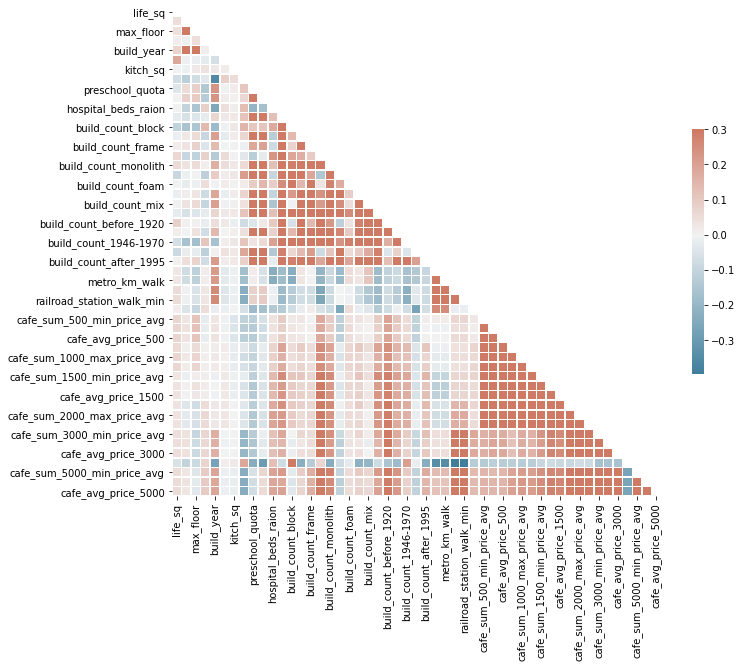

In [13]:
all_na_df = train_raw[na_columns]

##Overall build a corr grid graphic
#Build Correlation grid
na_corr = all_na_df.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(na_corr, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(na_corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


##### 2.1.3.1 Housing Categories

Below we have pulled together a correlation graph of the house category variables.
 
In the below graph we can see that there is some correlation ~.34 but none that would appear to be repetitive variables indicative of a .6 correlation or higher. Therefore we would leave all of the below variables in for prediction modeling.
 
Some noticeable relationships we see are between *max_floor*, *year_build*, *state*, and *floor*: we see that these variables are related but not to such an extent that it would be problematic for the prediction algorithm. In fact, their relationship is likely indicative of letting researchers know these variables should be used in helping with imputation of each other.

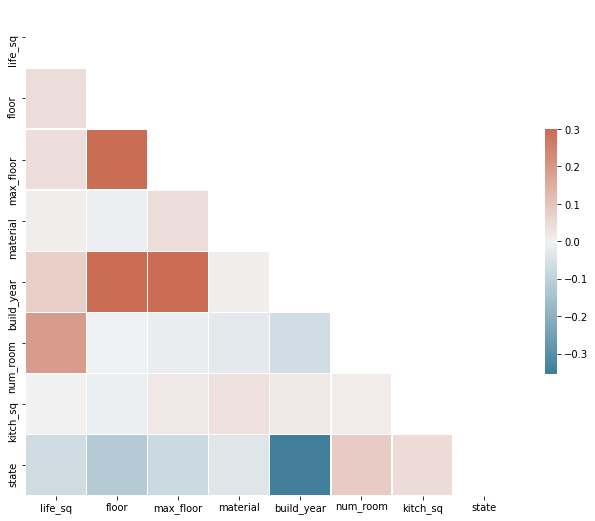

In [14]:
housing_var = ['life_sq',
 'floor',
 'max_floor',
 'material',
 'build_year',
 'num_room',
 'kitch_sq',
 'state']
housing_var_df = train_raw[housing_var]
housing_var_df.shape

##Overall build a corr grid graphic
#Build Correlation grid
house_corr = housing_var_df.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(house_corr, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(house_corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


##### 2.1.3.2 Schools & Hospital Categories

Below we have highlighted those hospital and school variables. We do see that there is a correlation between these variables both negative and positive of around ~.3 and ~-.2 respectively.
 
This relationship indicates MAR data as well as that using these variables to predict and impute the missing values of each variable would be a good course of action.


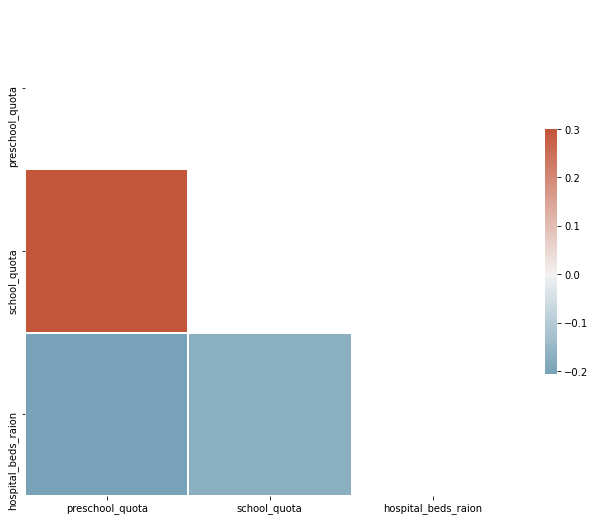

In [15]:
school_hosp_var = ['preschool_quota',
 'school_quota',
 'hospital_beds_raion']

school_hosp_df = train_raw[school_hosp_var]

##Overall build a corr grid graphic
#Build Correlation grid
school_corr = school_hosp_df.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(school_corr, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(school_corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


##### 2.1.3.3 Build Categories

Below we have highlighted those building material variables. As we have seen above to this point, we see a solid correlation between variables that hovers between ~-.1 to ~.3.
 
This again indicates there is a strong enough relationship that would help these variables to determine the possible values of the missing observations. We would want to move forward with imputation that takes this into account.


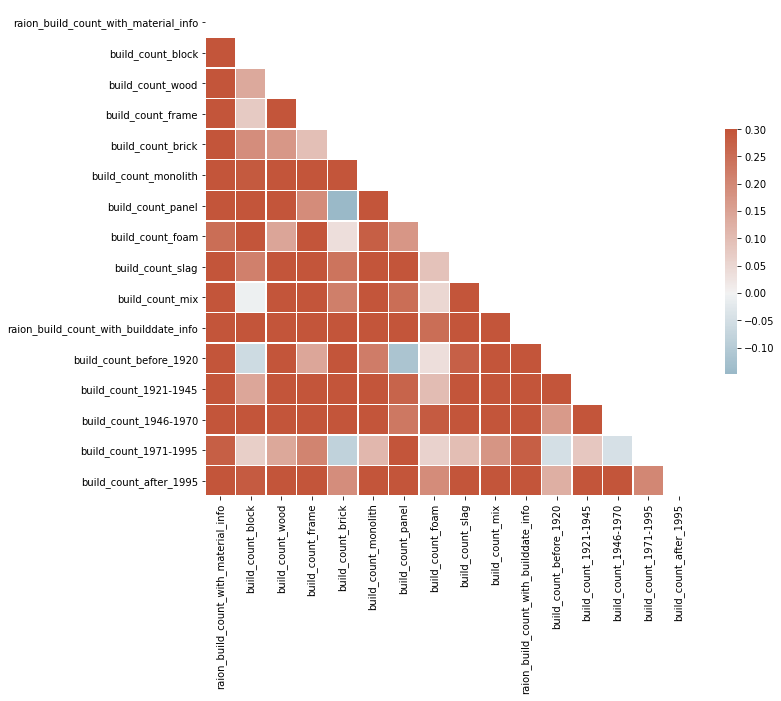

In [16]:
build_var = ['raion_build_count_with_material_info',
 'build_count_block',
 'build_count_wood',
 'build_count_frame',
 'build_count_brick',
 'build_count_monolith',
 'build_count_panel',
 'build_count_foam',
 'build_count_slag',
 'build_count_mix',
 'raion_build_count_with_builddate_info',
 'build_count_before_1920',
 'build_count_1921-1945',
 'build_count_1946-1970',
 'build_count_1971-1995',
 'build_count_after_1995']
build_var_df = train_raw[build_var]

##Overall build a corr grid graphic
#Build Correlation grid
build_corr = build_var_df.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(build_corr, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(build_corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


##### 2.1.3.4 Transit Categories

Below we have highlighted those transportation variables. We see a pretty steady correlation of about ~.3 between these variables. This is interesting and could imply these variables would be good at predicting the imputation of any missing observations between them. Our imputation method should take this into account.

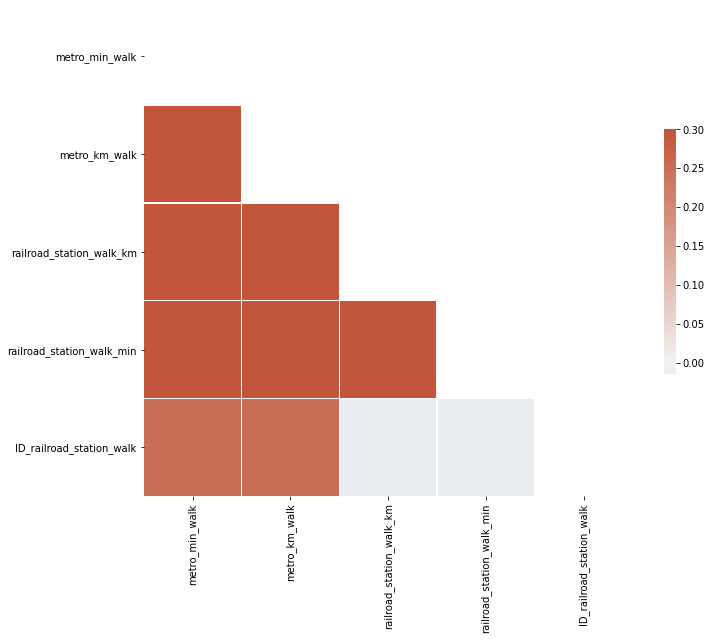

In [17]:
transit_var = ['metro_min_walk',
 'metro_km_walk',
 'railroad_station_walk_km',
 'railroad_station_walk_min',
 'ID_railroad_station_walk']
transit_var_df = train_raw[transit_var]

##Overall build a corr grid graphic
#Build Correlation grid
transit_corr = transit_var_df.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(transit_corr, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(transit_corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


##### 2.1.3.5 Cafe Categories

Below we have highlighted those cafe variables. We see a very steady correlation of around ~.3 with the *prom* variable being at a steady ~-.2. This would indicate again that these variables would be a good use of imputating across each other to determine those missing values since there is a clear relationship between them.

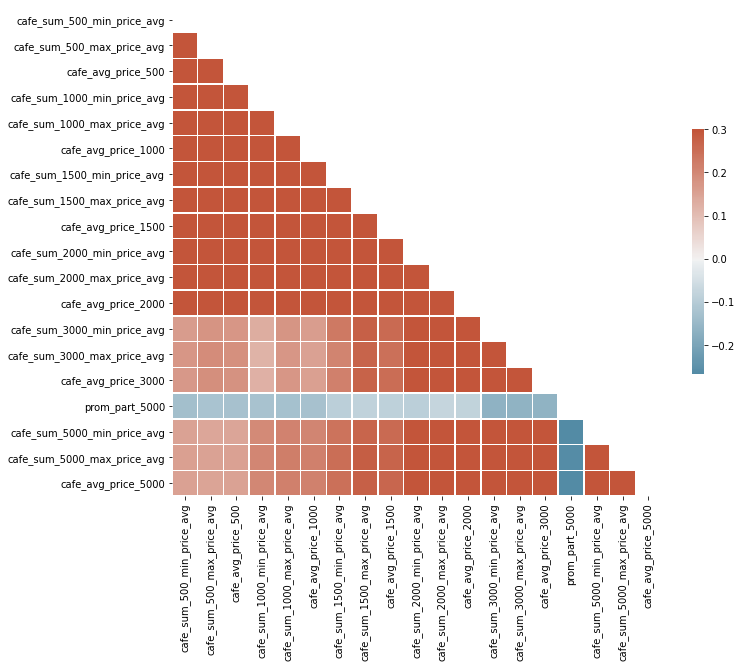

In [18]:
cafe_var = ['cafe_sum_500_min_price_avg',
 'cafe_sum_500_max_price_avg',
 'cafe_avg_price_500',
 'cafe_sum_1000_min_price_avg',
 'cafe_sum_1000_max_price_avg',
 'cafe_avg_price_1000',
 'cafe_sum_1500_min_price_avg',
 'cafe_sum_1500_max_price_avg',
 'cafe_avg_price_1500',
 'cafe_sum_2000_min_price_avg',
 'cafe_sum_2000_max_price_avg',
 'cafe_avg_price_2000',
 'cafe_sum_3000_min_price_avg',
 'cafe_sum_3000_max_price_avg',
 'cafe_avg_price_3000',
 'prom_part_5000',
 'cafe_sum_5000_min_price_avg',
 'cafe_sum_5000_max_price_avg',
 'cafe_avg_price_5000']
cafe_var_df = train_raw[cafe_var]

##Overall build a corr grid graphic
#Build Correlation grid
cafe_corr = cafe_var_df.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(cafe_corr, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(cafe_corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


#### 2.1.4 Missing Not At Random (nonignorable)

Data that is assumed to be missing not at random is nonignorable missing data. These are observations that researchers cannot confidently create conclusions about the likely value of missing data. These types of missing data are highly problematic for researchers. This is because it means researchers cannot use any of the common methods for dealing with missing data, for example imputation or algorithms that can use missing data variables. If researchers conclude that the data is missing not at random all analysis would be considered inaccurate or not relevant.
 
We have not elevated any sort of nonignorable data in our exploratory data analysis. Therefore we are able to move forward with data imputation methods that we explore later in this case study. However, had we been able to identify those data that were missing not at random, we would not have been able to perform a data imputation and would have had to explore other strategies for analysis.


In [19]:
train_raw['sub_area'].describe()

count                   30471
unique                    146
top       Poselenie Sosenskoe
freq                     1776
Name: sub_area, dtype: object

### 2.2 Conversion of Categorical Variables


In order to leverage some of the imputation methods available we decided to shift categorical variables into continuous variables. This will allow us to move forward with a single type of imputation method and leverage those relationships a little bit easier.

In [20]:
investment_encoded = pd.get_dummies(train_raw.product_type, prefix='product_type')
ecology_encoded = pd.get_dummies(train_raw.ecology, prefix='ecology')

train_raw = train_raw.drop(['product_type','sub_area','ecology'], axis = 1) 

list_yesno = ['culture_objects_top_25','thermal_power_plant_raion','incineration_raion',
              'oil_chemistry_raion','radiation_raion','railroad_terminal_raion','big_market_raion',
              'nuclear_reactor_raion','detention_facility_raion','water_1line','big_road1_1line','railroad_1line']
for item in list_yesno:
  train_raw[item] = train_raw[item].map( 
                   {'yes':1 ,'no':0}) 
train_raw = pd.concat([train_raw,investment_encoded,ecology_encoded], axis = 1)




In [21]:
#No more object types
train_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30471 entries, 0 to 30470
Columns: 293 entries, full_sq to ecology_satisfactory
dtypes: float64(119), int64(167), uint8(7)
memory usage: 66.7 MB


## 3. Imputation Methods

### 3.1 Single Imputation

Single imputation is the practice of replacing a single missing observation with what would or could have been a truly observed observation. There are many methods for single imputation that have been used and we are going to explore those here.

#### 3.1.1 Hot-deck

Hot-deck imputation was a previously commonly used method and is where a missing value is imputed from a randomly selected similar variable. The term *hot-deck* is in reference to was the data was stored and indicates that the donor information is sourced from the same dataset as the recipients.
 
One of the methods used for hot-deck imputation is *last observation carried forward*. The idea behind this method is that observations near each other in the dataset are related, so there is reason to believe carrying the last variable forward would suffice as a single imputation effort. This effort is known to increase bias by creating potentially false conclusions. This is not a highly recommended method and one we do not move forward with on our MAR data.

#### 3.1.2 Cold-deck

Cold-deck single imputation method is the opposite of the hot-deck imputation method, in that donor data that is sourced for the recipients does not originate from the same dataset. The idea behind this method was to replace missing values with similar data from other studies or observations made and recorded in another scenario.
 
Again, this method can introduce bias as the researchers are relying on the computational power of elevating relationships between two separate datasets in order to impute missing values. If there is another biased present it would affect those results and elevate false conclusions.

#### 3.1.3 Mean/Median subsitution

The mean or median substitution method is a well known single imputation method. This technique is driven by the concept of replacing missing values with the mean or median of the known values of that same variable in the dataset.
 
It is important to note that when using the mean substitution technique there is an accentuation of any correlative relationships between the imputed values and other variables that may have a relationship with that variable. This can be both an attractive and unattractive characteristic. For instance, for a multivariate analysis this would be a challenge and for a univariate analysis it would strengthen the method.


#### 3.1.4 Regression


Regression imputation is the process of estimating missing values by extrapolating those values with regression by leveraging those observed values as predictive variables. Differently stated, the available information in whole observations is used to complete those incomplete observations.
 
For regression used in this way it means all extrapolated values will not have any residual variance. The resulting regression models overfit those imputed values. Stochastic regression can be used to correct the missing error term for regression imputed values by including the average regression variance to the regression imputations. This helps result in less bias for the imputed values.


### 3.2 Multiple Imputation

Multiple imputation is a technique that was developed by Rubin in 1987, simply put, it is the method of averaging the outcomes across multiple imputed dataset to account for increased noise caused by imputation.
 
There are many different methods for this and they all follow 3 basic steps:
 
* Imputation – The imputed observations are drawn X times from a distribution. At the end of this step, there should be X completed datasets.
* Analysis – Every X dataset is analyzed. At the end of this step there should be X analyses.
* Pooling – The X results are consolidated into one result by calculating the mean, variance, and confidence interval of the variable of interest.
 
Unlike single imputation, multiple imputation is robust and can be used for many different types of missing data: such as MAR, MCAR, and MNAR. Additionally, multiple imputation is quite easy to implement. There are many algorithms available in order to complete multiple imputation. Since the data here depicts the MAR characteristics and multiple imputations are easily available, such as the KNNimputation ski-learn package, multiple imputation makes sense for us as researchers moving forward.


#### 3.2.1 KNN Imputation

KNN imputation or *nearest neighbor imputation* is a method of multiple imputation that leverages those relationships between variables to predict any missing observations.
 
KNN imputation works by discovering the samples in the training set that are closest to the missing observation, then averaging those near points in order to impute the missing value. The KNN method has proven to provide a more robust and sensitive method for missing observation replacement.
 
We will tune the KNN imputation for the distance measure between neighbors and the number of neighbors for each prediction.
 
After evaluation of the correlations and determining that the KNN imputation methods would work well for the variables we were able to determine had correlative relationships, we move forward with imputation of these grouped similar variables for each of the groups.


##### 3.2.1.1 House Characteristics Imputation

First we start with the house characteristic variables and use them to help predict those variables that are related. Below we've imputed those missing observations across the house characteristic variables.

In [22]:
full_cor = abs(raw_data.corr())

In [23]:
housing_var = ['life_sq',
 'floor',
 'max_floor',
 'material',
 'build_year',
 'num_room',
 'kitch_sq',
 'state']
housing_var_df = train_raw[housing_var]
housing_var_imp = housing_var_df.fillna(housing_var_df.median())
housing_var_imp.describe()

,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state
count,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00
mean,33.48,7.66,12.38,1.57,1983.28,1.94,6.27,2.06
std,46.52,5.31,5.60,1.29,15.35,0.71,23.41,0.63
min,0.00,0.00,0.00,1.00,1691.00,0.00,0.00,1.00
25%,22.00,3.00,9.00,1.00,1980.00,2.00,5.00,2.00
50%,30.00,6.50,12.00,1.00,1981.00,2.00,6.00,2.00
75%,38.00,11.00,16.00,1.00,1983.00,2.00,8.00,2.00
max,7478.00,77.00,117.00,6.00,2018.00,19.00,2014.00,4.00


##### 3.2.1.2 School & Hospital Variables Imputation

Here we've used the KNN imputation method for the school and hospital availability variables where the data depicted a relationship strong enough to indicate it would work with for multiple imputation of a MAR dataset.

In [24]:
school_corr = full_cor["preschool_quota"].sort_values(ascending = False) 

school_knn_var_o = ['preschool_quota',
 'school_quota',
 'hospital_beds_raion']

school_knn_var = ['preschool_quota',
 'school_quota',
 'hospital_beds_raion']
for idx,value in school_corr.items():
    if value > .5:
        school_knn_var.append(idx)
        print(idx, ": ", value)
school_knn_df = train_raw[school_knn_var]
school_knn_df.describe()

preschool_quota :  1.0
school_quota :  0.9316801467807214
build_count_panel :  0.8501747684470994
0_6_male :  0.8313667768355425
0_6_all :  0.8276133089123642
children_preschool :  0.8276133089123642
young_male :  0.8265748014276688
0_13_male :  0.8265593920076229
young_all :  0.8220595801412947
0_13_all :  0.8220007730832409
0_17_male :  0.8219489680740175
0_6_female :  0.8212586680609951
0_17_all :  0.8182524687475357
7_14_male :  0.8150830208819027
young_female :  0.8145994481230175
0_13_female :  0.8142903385381013
0_17_female :  0.8118430575618144
children_school :  0.8087931855473678
7_14_all :  0.8087931855473678
preschool_education_centers_raion :  0.80632631806565
7_14_female :  0.7978125396305912
work_female :  0.787176948728891
work_all :  0.7694145250526547
raion_popul :  0.7463075229285949
work_male :  0.7448013207407539
school_education_centers_raion :  0.7343660297707192
build_count_after_1995 :  0.6995300032517233
build_count_1971-1995 :  0.5993899977449133
ekder_female

,preschool_quota,school_quota,hospital_beds_raion,preschool_quota,school_quota,build_count_panel,0_6_male,0_6_all,children_preschool,young_male,0_13_male,young_all,0_13_all,0_17_male,0_6_female,0_17_all,7_14_male,young_female,0_13_female,0_17_female,children_school,7_14_all,preschool_education_centers_raion,7_14_female,work_female,work_all,raion_popul,work_male,school_education_centers_raion,build_count_after_1995,build_count_1971-1995,ekder_female,ekder_all,build_count_slag,raion_build_count_with_builddate_info,raion_build_count_with_material_info
count,23783.00,23786.00,16030.00,23783.00,23786.00,25480.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,25480.00,25480.00,30471.00,30471.00,25480.00,25480.00,25480.00
mean,3271.27,8324.97,1190.74,3271.27,8324.97,107.24,2631.20,5140.03,5140.03,5723.85,5037.27,11178.81,9841.10,6423.20,2508.96,12540.61,2743.47,5455.01,4803.83,6117.57,5354.27,5354.27,4.07,2610.95,26414.41,53667.91,84056.43,27253.59,4.71,61.15,80.13,13398.17,19209.71,4.49,328.33,328.66
std,2169.76,4289.73,1057.02,2169.76,4289.73,88.26,1973.22,3816.63,3816.63,4275.44,3760.75,8287.96,7290.01,4769.59,1846.60,9253.05,2054.52,4020.55,3536.91,4491.73,3989.64,3989.64,2.99,1941.38,18643.13,37483.56,57871.29,18939.15,3.45,114.22,57.87,9144.33,13174.72,13.23,277.92,277.90
min,0.00,1012.00,0.00,0.00,1012.00,0.00,91.00,175.00,175.00,189.00,166.00,365.00,322.00,214.00,85.00,411.00,87.00,177.00,156.00,198.00,168.00,168.00,0.00,82.00,771.00,1633.00,2546.00,863.00,0.00,0.00,0.00,393.00,548.00,0.00,1.00,1.00
25%,1874.00,5782.00,520.00,1874.00,5782.00,35.00,862.00,1706.00,1706.00,1782.00,1600.00,3459.00,3112.00,1973.00,844.00,3831.00,821.00,1677.00,1512.00,1858.00,1564.00,1564.00,2.00,743.00,6661.00,13996.00,21819.00,7394.00,2.00,14.00,37.00,3365.00,4695.00,0.00,178.00,180.00
50%,2854.00,7377.00,990.00,2854.00,7377.00,92.00,2435.00,4857.00,4857.00,5470.00,4835.00,10988.00,9633.00,6085.00,2390.00,12508.00,2693.00,5333.00,4667.00,6185.00,5261.00,5261.00,4.00,2535.00,26092.00,52030.00,83502.00,26382.00,5.00,24.00,71.00,13540.00,20036.00,0.00,271.00,273.00
75%,4050.00,9891.00,1786.00,4050.00,9891.00,157.00,3523.00,7103.00,7103.00,7597.00,6684.00,14906.00,13121.00,8599.00,3455.00,16727.00,3585.00,7617.00,6699.00,8549.00,7227.00,7227.00,6.00,3534.00,37942.00,77612.00,122862.00,38841.00,7.00,57.00,111.00,20165.00,29172.00,2.00,400.00,400.00
max,11926.00,24750.00,4849.00,11926.00,24750.00,431.00,9987.00,19223.00,19223.00,20977.00,18574.00,40692.00,36035.00,23233.00,9236.00,45170.00,9761.00,19715.00,17461.00,21937.00,19083.00,19083.00,13.00,9322.00,81668.00,161290.00,247469.00,79622.00,14.00,799.00,246.00,37811.00,57086.00,84.00,1680.00,1681.00


##### 3.2.1.3 Build Characteristics Variables Imputation

Below is our imputation of the build characteristic variables that all displayed correlation high enough to indicate a good prediction from the variables between each other to input missing observations.

In [25]:
build_corr = full_cor["raion_build_count_with_material_info"].sort_values(ascending = False) 

build_knn_var_o = build_var = ['raion_build_count_with_material_info',
 'build_count_block',
 'build_count_wood',
 'build_count_frame',
 'build_count_brick',
 'build_count_monolith',
 'build_count_panel',
 'build_count_foam',
 'build_count_slag',
 'build_count_mix',
 'raion_build_count_with_builddate_info',
 'build_count_before_1920',
 'build_count_1921-1945',
 'build_count_1946-1970',
 'build_count_1971-1995',
 'build_count_after_1995']

build_knn_var = build_var = ['raion_build_count_with_material_info',
 'build_count_block',
 'build_count_wood',
 'build_count_frame',
 'build_count_brick',
 'build_count_monolith',
 'build_count_panel',
 'build_count_foam',
 'build_count_slag',
 'build_count_mix',
 'raion_build_count_with_builddate_info',
 'build_count_before_1920',
 'build_count_1921-1945',
 'build_count_1946-1970',
 'build_count_1971-1995',
 'build_count_after_1995']
for idx,value in build_corr.items():
    if value > .5:
        build_knn_var.append(idx)
        print(idx, ": ", value)
build_knn_df = train_raw[set(build_knn_var)]
build_knn_df.describe()

raion_build_count_with_material_info :  1.0
raion_build_count_with_builddate_info :  0.9999896491801724
build_count_1921-1945 :  0.8531831827937478
build_count_slag :  0.8182416941351157
build_count_wood :  0.7950051193750644
build_count_after_1995 :  0.7881288647814467
build_count_1946-1970 :  0.7175401278702324
build_count_monolith :  0.7127533308903193
build_count_mix :  0.691638470540923
build_count_brick :  0.569125540597691
build_count_panel :  0.5399495525558676
school_quota :  0.5386938699932174
0_6_male :  0.5259775718747235
0_13_male :  0.5244463045088643
children_preschool :  0.523486731308184
0_6_all :  0.523486731308184
build_count_frame :  0.5233864045592358
young_male :  0.5216136027426953
0_13_all :  0.5202588655979483
0_17_male :  0.5199295268260096
0_6_female :  0.519484187551611
young_all :  0.5183431690597436
0_17_all :  0.5164739788879374
7_14_male :  0.5161779097485397
0_13_female :  0.5141949746092621
young_female :  0.5133788762152394
children_school :  0.511747

,young_all,build_count_slag,build_count_panel,build_count_1971-1995,children_school,0_6_all,raion_build_count_with_material_info,build_count_frame,children_preschool,build_count_monolith,7_14_all,build_count_block,build_count_mix,raion_build_count_with_builddate_info,build_count_foam,0_17_female,build_count_after_1995,preschool_quota,0_17_all,build_count_before_1920,build_count_1946-1970,build_count_brick,7_14_female,build_count_1921-1945,7_14_male,young_male,0_13_all,build_count_wood,0_13_male,school_quota,0_17_male,0_6_female,0_13_female,young_female,0_6_male
count,30471.00,25480.00,25480.00,25480.00,30471.00,30471.00,25480.00,25480.00,30471.00,25480.00,30471.00,25480.00,25480.00,25480.00,25480.00,30471.00,25480.00,23783.00,30471.00,25480.00,25480.00,25480.00,30471.00,25480.00,30471.00,30471.00,30471.00,25480.00,30471.00,23786.00,30471.00,30471.00,30471.00,30471.00,30471.00
mean,11178.81,4.49,107.24,80.13,5354.27,5140.03,328.66,4.95,5140.03,12.04,5354.27,50.30,0.57,328.33,0.17,6117.57,61.15,3271.27,12540.61,18.90,141.43,108.05,2610.95,26.72,2743.47,5723.85,9841.10,40.85,5037.27,8324.97,6423.20,2508.96,4803.83,5455.01,2631.20
std,8287.96,13.23,88.26,57.87,3989.64,3816.63,277.90,14.93,3816.63,19.28,3989.64,46.94,1.53,277.92,1.13,4491.73,114.22,2169.76,9253.05,60.98,125.43,129.12,1941.38,62.51,2054.52,4275.44,7290.01,126.74,3760.75,4289.73,4769.59,1846.60,3536.91,4020.55,1973.22
min,365.00,0.00,0.00,0.00,168.00,175.00,1.00,0.00,175.00,0.00,168.00,0.00,0.00,1.00,0.00,198.00,0.00,0.00,411.00,0.00,0.00,0.00,82.00,0.00,87.00,189.00,322.00,0.00,166.00,1012.00,214.00,85.00,156.00,177.00,91.00
25%,3459.00,0.00,35.00,37.00,1564.00,1706.00,180.00,0.00,1706.00,2.00,1564.00,13.00,0.00,178.00,0.00,1858.00,14.00,1874.00,3831.00,0.00,14.00,10.00,743.00,0.00,821.00,1782.00,3112.00,0.00,1600.00,5782.00,1973.00,844.00,1512.00,1677.00,862.00
50%,10988.00,0.00,92.00,71.00,5261.00,4857.00,273.00,0.00,4857.00,6.00,5261.00,42.00,0.00,271.00,0.00,6185.00,24.00,2854.00,12508.00,0.00,135.00,67.00,2535.00,2.00,2693.00,5470.00,9633.00,0.00,4835.00,7377.00,6085.00,2390.00,4667.00,5333.00,2435.00
75%,14906.00,2.00,157.00,111.00,7227.00,7103.00,400.00,1.00,7103.00,13.00,7227.00,72.00,0.00,400.00,0.00,8549.00,57.00,4050.00,16727.00,3.00,216.00,156.00,3534.00,20.00,3585.00,7597.00,13121.00,7.00,6684.00,9891.00,8599.00,3455.00,6699.00,7617.00,3523.00
max,40692.00,84.00,431.00,246.00,19083.00,19223.00,1681.00,97.00,19223.00,127.00,19083.00,223.00,9.00,1680.00,11.00,21937.00,799.00,11926.00,45170.00,371.00,845.00,664.00,9322.00,382.00,9761.00,20977.00,36035.00,793.00,18574.00,24750.00,23233.00,9236.00,17461.00,19715.00,9987.00


##### 3.2.1.4 Transportation Variables Imputation

Below we have broken out those transportation variables with the observed correlative relationships in order to allow the KNN imputation method to help extrapolate the missing observations between these variables.

In [26]:
transit_corr = full_cor["metro_min_walk"].sort_values(ascending = False) 

transit_var_o = ['metro_min_walk',
 'metro_km_walk',
 'railroad_station_walk_km',
 'railroad_station_walk_min',
 'ID_railroad_station_walk']

transit_var = ['metro_min_walk',
 'metro_km_walk',
 'railroad_station_walk_km',
 'railroad_station_walk_min',
 'ID_railroad_station_walk']
for idx,value in transit_corr.items():
    if value > .5:
        transit_var.append(idx)
        print(idx, ": ", value)
transit_knn_df = train_raw[transit_var]
transit_knn_df.describe()

metro_km_walk :  1.000000000000037
metro_min_walk :  1.0
metro_km_avto :  0.9867536432864107
metro_min_avto :  0.9387101750089363
radiation_km :  0.9116024070230332
park_km :  0.9052469413587
power_transmission_line_km :  0.8946702899482183
ts_km :  0.8876185000097571
exhibition_km :  0.8787031686508481
basketball_km :  0.874618661544777
thermal_power_plant_km :  0.8737203633773188
big_church_km :  0.8114585920601892
ttk_km :  0.8109017066421603
stadium_km :  0.796755474353745
sadovoe_km :  0.7893202078585245
bus_terminal_avto_km :  0.7808116459647668
bulvar_ring_km :  0.7807490177437528
kremlin_km :  0.7805397792129126
swim_pool_km :  0.7706604009035235
school_km :  0.7653419314180313
preschool_km :  0.7645166457649036
zd_vokzaly_avto_km :  0.7544582494873164
public_healthcare_km :  0.7364809181660281
incineration_km :  0.7355401755685517
mkad_km :  0.7321500271833559
nuclear_reactor_km :  0.7317528727148473
shopping_centers_km :  0.7146914773393879
oil_chemistry_km :  0.7138400032141

,metro_min_walk,metro_km_walk,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk,metro_km_walk,metro_min_walk,metro_km_avto,metro_min_avto,radiation_km,park_km,power_transmission_line_km,ts_km,exhibition_km,basketball_km,thermal_power_plant_km,big_church_km,ttk_km,stadium_km,sadovoe_km,bus_terminal_avto_km,bulvar_ring_km,kremlin_km,swim_pool_km,school_km,preschool_km,zd_vokzaly_avto_km,public_healthcare_km,incineration_km,mkad_km,nuclear_reactor_km,shopping_centers_km,oil_chemistry_km,mosque_km,detention_facility_km,workplaces_km,additional_education_km,kindergarten_km,public_transport_station_min_walk,public_transport_station_km,hospice_morgue_km,fitness_km,ice_rink_km,big_market_km,university_km,area_m,market_shop_km,catering_km,museum_km,office_km,theater_km,big_road2_km
count,30446.00,30446.00,30446.00,30446.00,30446.00,30446.00,30446.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00
mean,42.74,3.56,4.39,52.64,38.86,3.56,42.74,3.70,4.96,4.41,3.10,3.49,4.93,5.55,4.79,7.34,2.33,11.32,9.44,14.06,9.99,15.02,16.04,4.23,1.32,1.35,17.21,3.36,10.88,6.27,10.95,1.51,17.40,7.74,14.55,3.93,1.33,0.98,4.97,0.41,2.65,1.15,6.12,13.28,6.86,17657051.42,3.96,0.69,7.06,2.01,9.64,3.40
std,69.30,5.78,3.84,46.04,27.77,5.78,69.30,5.81,6.55,5.60,3.97,4.55,4.80,5.30,5.40,5.62,2.99,8.07,7.64,8.34,7.33,8.48,8.44,4.63,3.06,3.05,10.30,4.34,6.79,5.14,7.25,2.25,10.40,5.78,11.08,4.91,1.53,2.12,15.27,1.27,2.95,1.54,4.67,8.50,6.73,20649607.99,3.45,0.83,5.70,2.31,7.11,1.87
min,0.00,0.00,0.03,0.34,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.03,0.00,0.01,0.01,0.40,0.00,0.00,0.11,0.00,0.06,0.00,0.07,0.00,0.00,0.00,0.14,0.00,0.20,0.01,0.31,0.00,0.51,0.01,0.04,0.00,0.00,0.00,0.03,0.00,0.00,0.00,0.00,0.66,0.00,2081627.76,0.00,0.00,0.01,0.00,0.03,0.00
25%,11.48,0.96,1.93,23.18,18.00,0.96,11.48,1.04,1.72,1.23,0.97,0.98,2.06,2.24,1.31,3.77,0.86,5.34,4.02,8.35,5.21,9.26,10.46,1.71,0.27,0.29,9.99,1.28,6.22,2.63,5.24,0.48,8.72,3.77,5.67,1.02,0.47,0.20,1.22,0.10,1.12,0.36,3.04,7.53,2.20,7307410.57,1.54,0.21,2.88,0.56,4.23,2.10
50%,20.45,1.70,3.24,38.83,33.00,1.70,20.45,1.78,2.80,2.44,1.80,1.90,3.97,4.11,2.88,5.89,1.49,9.84,6.97,12.75,7.45,13.61,14.88,2.88,0.47,0.49,14.76,2.34,10.32,5.47,8.97,0.84,16.70,6.54,11.31,2.03,0.90,0.35,1.92,0.16,1.90,0.66,5.55,11.91,4.34,10508030.10,2.93,0.41,5.64,1.05,8.61,3.21
75%,45.32,3.78,5.15,61.77,53.00,3.78,45.32,3.78,4.83,4.69,3.40,4.93,5.55,6.97,6.36,9.82,2.92,15.68,13.59,18.72,13.28,19.95,20.67,5.37,0.89,0.94,24.06,3.98,13.39,8.18,16.37,1.55,23.42,10.05,24.88,5.42,1.57,0.97,3.34,0.28,3.30,1.33,7.96,16.56,9.38,18036436.51,5.49,0.84,10.33,3.05,13.46,4.32
max,711.22,59.27,24.65,295.84,133.00,59.27,711.22,74.91,61.44,53.89,47.35,43.32,54.08,54.43,56.70,56.86,45.67,66.03,83.40,68.85,74.80,69.98,70.74,53.36,47.39,47.39,91.22,76.06,58.63,53.28,64.26,26.26,70.41,44.85,89.37,55.28,24.27,29.09,208.96,17.41,43.69,26.65,46.04,59.50,84.86,206071809.20,41.10,12.16,59.20,18.96,87.60,13.80


##### 3.2.1.5 Cafe Variables Imputation

Below we have broken out those well correlated values with *cafe* as a reference to leverage KNN imputation to predict those missing observations.

In [27]:
cafe_corr = full_cor["cafe_avg_price_5000"].sort_values(ascending = False) 

cafe_knn_var_o = ['cafe_sum_500_min_price_avg',
 'cafe_sum_500_max_price_avg',
 'cafe_avg_price_500',
 'cafe_sum_1000_min_price_avg',
 'cafe_sum_1000_max_price_avg',
 'cafe_avg_price_1000',
 'cafe_sum_1500_min_price_avg',
 'cafe_sum_1500_max_price_avg',
 'cafe_avg_price_1500',
 'cafe_sum_2000_min_price_avg',
 'cafe_sum_2000_max_price_avg',
 'cafe_avg_price_2000',
 'cafe_sum_3000_min_price_avg',
 'cafe_sum_3000_max_price_avg',
 'cafe_avg_price_3000',
 'prom_part_5000',
 'cafe_sum_5000_min_price_avg',
 'cafe_sum_5000_max_price_avg',
 'cafe_avg_price_5000']

cafe_knn_var = ['cafe_sum_500_min_price_avg',
 'cafe_sum_500_max_price_avg',
 'cafe_avg_price_500',
 'cafe_sum_1000_min_price_avg',
 'cafe_sum_1000_max_price_avg',
 'cafe_avg_price_1000',
 'cafe_sum_1500_min_price_avg',
 'cafe_sum_1500_max_price_avg',
 'cafe_avg_price_1500',
 'cafe_sum_2000_min_price_avg',
 'cafe_sum_2000_max_price_avg',
 'cafe_avg_price_2000',
 'cafe_sum_3000_min_price_avg',
 'cafe_sum_3000_max_price_avg',
 'cafe_avg_price_3000',
 'prom_part_5000',
 'cafe_sum_5000_min_price_avg',
 'cafe_sum_5000_max_price_avg',
 'cafe_avg_price_5000']
for idx,value in cafe_corr.items():
    if value > .3:
        cafe_knn_var.append(idx)
        print(idx, ": ", value)
cafe_knn_df = train_raw[set(cafe_knn_var)]
cafe_knn_df.describe()

cafe_avg_price_5000 :  1.0
cafe_sum_5000_max_price_avg :  0.9993671518925642
cafe_sum_5000_min_price_avg :  0.9984793661201671
cafe_sum_3000_max_price_avg :  0.6826680311856125
cafe_avg_price_3000 :  0.6815344428956625
cafe_sum_3000_min_price_avg :  0.676765262310558
shopping_centers_km :  0.5440107313667905
ID_big_road1 :  0.514048087239169
railroad_station_avto_km :  0.49908884969180956
preschool_km :  0.48550752038773953
school_km :  0.48525108236192066
railroad_km :  0.48024726904112225
cafe_sum_2000_max_price_avg :  0.4745146780977593
cafe_avg_price_2000 :  0.4616043185200006
railroad_station_walk_km :  0.45944271355779503
railroad_station_walk_min :  0.45944271351552707
area_m :  0.45615675123166527
cafe_sum_2000_min_price_avg :  0.4369696514001072
museum_km :  0.42132339899995747
swim_pool_km :  0.415324516652836
public_healthcare_km :  0.41401874786510007
railroad_station_avto_min :  0.3991655334038012
big_church_km :  0.3883537242613776
office_km :  0.38347215122836836
ice_rin

,cafe_sum_3000_min_price_avg,cafe_sum_5000_max_price_avg,big_church_km,shopping_centers_km,cafe_sum_500_max_price_avg,kindergarten_km,railroad_km,cafe_avg_price_5000,office_km,cafe_sum_1000_max_price_avg,school_km,cafe_sum_1500_min_price_avg,cafe_sum_500_min_price_avg,museum_km,railroad_station_walk_min,cafe_avg_price_1500,cafe_avg_price_3000,swim_pool_km,ID_big_road1,preschool_km,university_km,railroad_station_walk_km,cafe_sum_2000_min_price_avg,cafe_avg_price_500,public_healthcare_km,cafe_sum_3000_max_price_avg,railroad_station_avto_km,workplaces_km,public_transport_station_km,cafe_sum_1000_min_price_avg,build_count_brick,public_transport_station_min_walk,ice_rink_km,railroad_station_avto_min,cafe_avg_price_2000,market_shop_km,prom_part_5000,area_m,cafe_sum_5000_min_price_avg,cafe_sum_1500_max_price_avg,cafe_sum_2000_max_price_avg,cafe_avg_price_1000,additional_education_km
count,29480.00,30174.00,30471.00,30471.00,17190.00,30471.00,30471.00,30174.00,30471.00,23947.00,30471.00,26272.00,17190.00,30471.00,30446.00,26272.00,29480.00,30471.00,30471.00,30471.00,30471.00,30446.00,28746.00,17190.00,30471.00,29480.00,30471.00,30471.00,30471.00,23947.00,25480.00,30471.00,30471.00,30471.00,28746.00,30471.00,30293.00,30471.00,30174.00,26272.00,28746.00,23947.00,30471.00
mean,765.90,1278.28,2.33,1.51,1247.02,0.98,1.89,1021.69,2.01,1206.62,1.32,714.06,741.32,7.06,52.64,960.04,1024.62,4.23,11.52,1.35,6.86,4.39,719.98,994.17,3.36,1283.33,4.59,3.93,0.41,710.92,108.05,4.97,6.12,6.09,965.44,3.96,10.35,17657051.42,765.10,1206.01,1210.91,958.77,1.33
std,224.01,236.21,2.99,2.25,526.54,2.12,1.97,194.12,2.31,343.13,3.06,192.26,341.10,5.70,46.04,240.67,288.16,4.63,11.35,3.05,6.73,3.84,199.37,432.52,4.34,353.30,3.91,4.91,1.27,224.43,129.12,15.27,4.67,4.79,250.01,3.45,5.67,20649607.99,152.41,291.30,302.83,282.63,1.53
min,300.00,500.00,0.00,0.00,500.00,0.00,0.00,400.00,0.00,500.00,0.00,300.00,300.00,0.01,0.34,400.00,400.00,0.00,1.00,0.00,0.00,0.03,300.00,400.00,0.00,500.00,0.03,0.00,0.00,300.00,0.00,0.03,0.00,0.04,400.00,0.00,0.21,2081627.76,300.00,500.00,500.00,400.00,0.00
25%,650.00,1144.23,0.86,0.48,1000.00,0.20,0.66,909.38,0.56,1000.00,0.27,585.71,500.00,2.88,23.18,795.00,875.80,1.71,2.00,0.29,2.20,1.93,607.69,750.00,1.28,1102.27,2.12,1.02,0.10,543.17,10.00,1.22,3.04,3.24,823.47,1.54,6.05,7307410.57,670.87,1000.00,1000.00,750.00,0.47
50%,711.11,1211.95,1.49,0.84,1166.67,0.35,1.24,966.67,1.05,1142.86,0.47,692.31,666.67,5.64,38.83,926.32,961.11,2.88,10.00,0.49,4.34,3.24,683.33,916.67,2.34,1211.54,3.43,2.03,0.16,669.23,67.00,1.92,5.55,4.94,919.23,2.93,8.98,10508030.10,721.74,1166.67,1156.25,912.50,0.90
75%,815.63,1346.09,2.92,1.55,1500.00,0.97,2.52,1091.67,3.05,1400.00,0.89,821.43,954.84,10.33,61.77,1093.75,1083.33,5.37,14.00,0.94,9.38,5.15,791.67,1250.00,3.98,1333.33,5.39,5.42,0.28,839.29,156.00,3.34,7.96,7.30,1057.24,5.49,14.00,18036436.51,816.66,1366.67,1321.62,1120.00,1.57
max,1833.33,3000.00,45.67,26.26,6000.00,29.09,17.39,2437.50,18.96,4000.00,47.39,2500.00,4000.00,59.20,295.84,3250.00,2416.67,53.36,48.00,47.39,84.86,24.65,2166.67,5000.00,76.06,3000.00,24.65,55.28,17.41,2500.00,664.00,208.96,46.04,38.69,2833.33,41.10,28.56,206071809.20,1875.00,4000.00,3500.00,3250.00,24.27


In [28]:
train_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30471 entries, 0 to 30470
Columns: 293 entries, full_sq to ecology_satisfactory
dtypes: float64(119), int64(167), uint8(7)
memory usage: 66.7 MB


In [29]:
train_raw.describe()

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,male_f,female_f,...,cafe_count_3000_price_1500,cafe_count_3000_price_2500,cafe_count_3000_price_4000,cafe_count_3000_price_high,big_church_count_3000,church_count_3000,mosque_count_3000,leisure_count_3000,sport_count_3000,market_count_3000,green_part_5000,prom_part_5000,office_count_5000,office_sqm_5000,trc_count_5000,trc_sqm_5000,cafe_count_5000,cafe_sum_5000_min_price_avg,cafe_sum_5000_max_price_avg,cafe_avg_price_5000,cafe_count_5000_na_price,cafe_count_5000_price_500,cafe_count_5000_price_1000,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,product_type_Investment,product_type_OwnerOccupier,ecology_excellent,ecology_good,ecology_no data,ecology_poor,ecology_satisfactory
count,30471.00,24088.00,30304.00,20899.00,20899.00,15961.00,20899.00,20899.00,16911.00,30471.00,30471.00,30471.00,30471.00,30471.00,23783.00,30471.00,30471.00,23786.00,30471.00,30471.00,16030.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,...,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30293.00,30471.00,30471.00,30471.00,30471.00,30471.00,30174.00,30174.00,30174.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00
mean,54.21,34.40,7.67,12.56,1.83,1985.35,1.91,6.40,2.11,17657051.42,84056.43,0.22,0.12,5140.03,3271.27,4.07,5354.27,8324.97,4.71,0.11,1190.74,1.32,0.14,6.64,2.90,0.06,0.29,4.20,8.25,0.05,0.08,0.01,0.36,0.04,0.09,0.03,0.10,146306.15,67207.79,79098.66,...,26.69,13.32,4.65,0.71,6.12,12.29,0.20,3.88,20.24,2.32,22.77,10.35,71.36,1401057.39,30.13,1173871.15,265.53,765.10,1278.28,1021.69,17.81,66.20,73.44,63.47,32.06,10.78,1.77,15.05,30.25,0.44,8.65,52.80,5.99,0.64,0.36,0.13,0.24,0.25,0.26,0.12
std,38.03,52.29,5.32,6.76,1.48,21.00,0.85,28.27,0.85,20649607.99,57871.29,0.18,0.12,3816.63,2169.76,2.99,3989.64,4289.73,3.45,0.33,1057.02,1.49,0.44,6.57,3.29,0.24,1.51,4.74,23.54,0.23,0.27,0.10,0.48,0.19,0.29,0.17,0.30,283025.12,129444.56,153630.89,...,70.86,41.28,16.88,2.78,15.41,25.79,0.45,13.19,18.84,2.27,11.21,5.67,155.34,2303052.49,23.92,1004809.88,514.54,152.41,236.21,194.12,33.27,125.93,126.17,124.08,73.47,28.39,5.42,29.12,47.35,0.61,20.58,46.29,4.89,0.48,0.48,0.34,0.42,0.43,0.44,0.33
min,0.00,0.00,0.00,0.00,1.00,1691.00,0.00,0.00,1.00,2081627.76,2546.00,0.00,0.00,175.00,0.00,0.00,168.00,1012.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2546.00,1208.00,1341.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.52,0.21,0.00,0.00,0.00,0.00,0.00,300.00,500.00,400.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,38.00,20.00,3.00,9.00,1.00,1968.00,1.00,1.00,1.00,7307410.57,21819.00,0.06,0.02,1706.00,1874.00,2.00,1564.00,5782.00,2.00,0.00,520.00,0.00,0.00,1.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,28179.00,13522.00,15031.00,...,2.00,1.00,0.00,0.00,1.00,3.00,0.00,0.00,5.00,0.00,14.78,6.05

### 3.3 Simple Imputation

In order to have a baseline for our multiple imputation method we completed a simple imputation for comparison. 

We replaced all unknown values with -1 in order to compare RMSE performance to see how well our multiple imputation method performaed when compared with simple imputation.

In [30]:
simple_imp_df = train_raw.fillna(-1)
simple_imp_df.describe()

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,male_f,female_f,...,cafe_count_3000_price_1500,cafe_count_3000_price_2500,cafe_count_3000_price_4000,cafe_count_3000_price_high,big_church_count_3000,church_count_3000,mosque_count_3000,leisure_count_3000,sport_count_3000,market_count_3000,green_part_5000,prom_part_5000,office_count_5000,office_sqm_5000,trc_count_5000,trc_sqm_5000,cafe_count_5000,cafe_sum_5000_min_price_avg,cafe_sum_5000_max_price_avg,cafe_avg_price_5000,cafe_count_5000_na_price,cafe_count_5000_price_500,cafe_count_5000_price_1000,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,product_type_Investment,product_type_OwnerOccupier,ecology_excellent,ecology_good,ecology_no data,ecology_poor,ecology_satisfactory
count,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,...,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00
mean,54.21,26.99,7.62,8.30,0.94,1039.47,1.00,4.07,0.72,17657051.42,84056.43,0.22,0.12,5140.03,2553.05,4.07,5354.27,6498.34,4.71,0.11,625.94,1.32,0.14,6.64,2.90,0.06,0.29,4.20,8.25,0.05,0.08,0.01,0.36,0.04,0.09,0.03,0.10,146306.15,67207.79,79098.66,...,26.69,13.32,4.65,0.71,6.12,12.29,0.20,3.88,20.24,2.32,22.77,10.28,71.36,1401057.39,30.13,1173871.15,265.53,757.63,1265.81,1011.72,17.81,66.20,73.44,63.47,32.06,10.78,1.77,15.05,30.25,0.44,8.65,52.80,5.99,0.64,0.36,0.13,0.24,0.25,0.26,0.12
std,38.03,48.67,5.34,8.42,1.80,992.18,1.52,23.66,1.67,20649607.99,57871.29,0.18,0.12,3816.63,2347.11,2.99,3989.64,5122.19,3.45,0.33,970.50,1.49,0.44,6.57,3.29,0.24,1.51,4.74,23.54,0.23,0.27,0.10,0.48,0.19,0.29,0.17,0.30,283025.12,129444.56,153630.89,...,70.86,41.28,16.88,2.78,15.41,25.79,0.45,13.19,18.84,2.27,11.21,5.72,155.34,2303052.49,23.92,1004809.88,514.54,169.31,266.55,217.74,33.27,125.93,126.17,124.08,73.47,28.39,5.42,29.12,47.35,0.61,20.58,46.29,4.89,0.48,0.48,0.34,0.42,0.43,0.44,0.33
min,0.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,2081627.76,2546.00,0.00,0.00,175.00,-1.00,0.00,168.00,-1.00,0.00,0.00,-1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2546.00,1208.00,1341.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.52,-1.00,0.00,0.00,0.00,0.00,0.00,-1.00,-1.00,-1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,38.00,16.00,3.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00,7307410.57,21819.00,0.06,0.02,1706.00,866.00,2.00,1564.00,2730.00,2.00,0.00,-1.00,0.00,0.00,1.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,28179.00,13522.00,15031.00,...,2.00,1.00,0.00,0.00,1.00,3.00,0.00,0.00,5.00,0.00,14.78,6.

## 4. Model: ElasticNet Regression

### 4.1 KNN Imputation & ElasticNet Hyperparameter Tuning

We tuned our KNN imputation and elastic net models with the following hyperparameters:

KNN Imputation Hyperparameters
* n_neighbors: Number of neighboring samples to use for imputation

ElasticNet Hyperparameters
* alpha: controls the regularization of the model. It is the number of alphas along the regularization path, used for each l1_ratio

* l1_ratio: this represents the ratio between the L1 and L2 regularization.

Tuning the imputation method and actual model in the same loop made sure we generated the model with the lowest possible RMSE.

In [38]:
%%time

train_imputed = train_raw.copy()
n = 1
kList = [5, 25]
lList = [.1, .5, .9, 1]
aList = [100, 150, 300]

for k in kList:
  for l in lList:
    for a in aList:
      # Imputation Step:
      imputer = KNNImputer(n_neighbors=k, weights='distance', metric='nan_euclidean')

      # House Variable Imputation
      imputedHousingData = housing_var_imp.copy()
      imputedHousingData = imputedHousingData[housing_var]

      # School Variable Imputation
      imputedSchoolData = pd.DataFrame(imputer.fit_transform(school_knn_df))
      imputedSchoolData.columns = school_knn_df.columns
      imputedSchoolData = imputedSchoolData[school_knn_var_o]

      # Build Variable Imputation
      imputedBuildData = pd.DataFrame(imputer.fit_transform(build_knn_df))
      imputedBuildData.columns = build_knn_df.columns
      imputedBuildData = imputedBuildData[build_knn_var_o]

      # Transit Variable Imputation
      imputedTransitData = pd.DataFrame(imputer.fit_transform(transit_knn_df))
      imputedTransitData.columns = transit_knn_df.columns
      imputedTransitData = imputedTransitData[transit_var_o]

      # Cafe Variable Imputation
      imputedCafeData = pd.DataFrame(imputer.fit_transform(cafe_knn_df))
      imputedCafeData.columns = cafe_knn_df.columns
      imputedCafeData = imputedCafeData[cafe_knn_var_o]

      train_imputed = train_imputed.drop(housing_var, axis = 1) 
      train_imputed = train_imputed.drop(school_knn_var_o, axis = 1) 
      train_imputed = train_imputed.drop(build_knn_var_o, axis = 1) 
      train_imputed = train_imputed.drop(transit_var_o, axis = 1) 
      train_imputed = train_imputed.drop(cafe_knn_var_o, axis = 1) 

      train_imputed = pd.merge(train_imputed, imputedHousingData, left_index=True, right_index=True)
      train_imputed = pd.merge(train_imputed, imputedSchoolData, left_index=True, right_index=True)
      train_imputed = pd.merge(train_imputed, imputedBuildData, left_index=True, right_index=True)
      train_imputed = pd.merge(train_imputed, imputedTransitData, left_index=True, right_index=True)
      train_imputed = pd.merge(train_imputed, imputedCafeData, left_index=True, right_index=True)

      train_imputed = train_imputed.loc[:,~train_imputed.columns.duplicated()]

      # Model Step
      en = ElasticNetCV(l1_ratio = l, n_alphas= a, cv=5, n_jobs=5, random_state = 13)

      en.fit(train_imputed, target)
      preds_ki = en.predict(train_imputed)
      rmse_ki = np.sqrt(mean_squared_error(preds_ki, target))

      print("MODEL ", n, ": ", "k:", k, "l:", l, "a:", a, "RMSE: ", rmse_ki)

      n = n + 1

print('')
print('')
train_imputed.info()

MODEL  1 :  k: 5 l: 0.1 a: 100 RMSE:  4547456.109957799
MODEL  2 :  k: 5 l: 0.1 a: 150 RMSE:  4547456.109957799
MODEL  3 :  k: 5 l: 0.1 a: 300 RMSE:  4547456.109957799
MODEL  4 :  k: 5 l: 0.5 a: 100 RMSE:  4520995.646775338
MODEL  5 :  k: 5 l: 0.5 a: 150 RMSE:  4520995.646775338
MODEL  6 :  k: 5 l: 0.5 a: 300 RMSE:  4520995.646775338
MODEL  7 :  k: 5 l: 0.9 a: 100 RMSE:  4505907.1495436
MODEL  8 :  k: 5 l: 0.9 a: 150 RMSE:  4505907.1495436
MODEL  9 :  k: 5 l: 0.9 a: 300 RMSE:  4505907.1495436
MODEL  10 :  k: 5 l: 1 a: 100 RMSE:  4499020.403661752
MODEL  11 :  k: 5 l: 1 a: 150 RMSE:  4499020.403661752
MODEL  12 :  k: 5 l: 1 a: 300 RMSE:  4499020.403661752
MODEL  13 :  k: 25 l: 0.1 a: 100 RMSE:  4547456.109957799
MODEL  14 :  k: 25 l: 0.1 a: 150 RMSE:  4547456.109957799
MODEL  15 :  k: 25 l: 0.1 a: 300 RMSE:  4547456.109957799
MODEL  16 :  k: 25 l: 0.5 a: 100 RMSE:  4520995.646775338
MODEL  17 :  k: 25 l: 0.5 a: 150 RMSE:  4520995.646775338
MODEL  18 :  k: 25 l: 0.5 a: 300 RMSE:  4520995

In [32]:
train_imputed.describe()

,full_sq,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_education_centers_raion,children_school,school_education_centers_raion,school_education_centers_top_20_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,...,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,metro_min_walk,metro_km_walk,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_sum_2000_min_price_avg,cafe_sum_2000_max_price_avg,cafe_avg_price_2000,cafe_sum_3000_min_price_avg,cafe_sum_3000_max_price_avg,cafe_avg_price_3000,prom_part_5000,cafe_sum_5000_min_price_avg,cafe_sum_5000_max_price_avg,cafe_avg_price_5000
count,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,...,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00,30471.00
mean,54.21,17657051.42,84056.43,0.22,0.12,5140.03,4.07,5354.27,4.71,0.11,1.32,0.14,6.64,2.90,0.06,0.29,4.20,8.25,0.05,0.08,0.01,0.36,0.04,0.09,0.03,0.10,146306.15,67207.79,79098.66,11178.81,5723.85,5455.01,53667.91,27253.59,26414.41,19209.71,5811.62,13398.17,5140.03,2631.20,...,329.95,42.94,72.24,6.82,99.66,10.38,90.23,0.14,6.95,0.60,329.67,17.53,37.55,150.53,69.34,54.72,42.72,3.56,4.39,52.63,38.87,699.50,1196.79,948.15,681.08,1170.17,925.63,693.11,1174.57,933.84,725.68,1218.85,972.27,767.67,1283.53,1025.60,10.29,770.93,1287.91,1029.42
std,38.03,20649607.99,57871.29,0.18,0.12,3816.63,2.99,3989.64,3.45,0.33,1.49,0.44,6.57,3.29,0.24,1.51,4.74,23.54,0.23,0.27,0.10,0.48,0.19,0.29,0.17,0.30,283025.12,129444.56,153630.89,8287.96,4275.44,4020.55,37483.56,18939.15,18643.13,13174.72,4073.83,9144.33,3816.63,1973.22,...,292.85,46.10,177.02,16.42,120.62,18.06,89.41,1.04,16.48,1.46,292.86,56.11,75.27,144.02,58.49,105.98,69.28,5.77,3.84,46.03,27.77,342.09,521.27,430.13,241.74,367.76,303.34,207.00,314.49,259.38,213.30,321.05,265.98,225.10,354.85,289.41,5.70,164.39,257.19,210.60
min,0.00,2081627.76,2546.00,0.00,0.00,175.00,0.00,168.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2546.00,1208.00,1341.00,365.00,189.00,177.00,1633.00,863.00,771.00,548.00,156.00,393.00,175.00,91.00,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.03,0.34,1.00,300.00,500.00,400.00,300.00,500.00,400.00,300.00,500.00,400.00,300.00,500.00,400.00,300.00,500.00,400.00,0.21,300.00,500.00,400.00
25%,38.00,7307410.57,21819.00,0.06,0.02,1706.00,2.00,1564.00,2.00,0.00,0.00,0.00,1.00,1.0

Ensuring that the imputation process removed all missing values.

In [33]:
naCols = 0
naCells = 0
na_columns = []
for col in train_imputed.columns:
  if train_imputed[col].isna().sum() > 0:
    na_columns.append(col)
    print(col," NAs:   ",train_imputed[col].isna().sum())
    naCols = naCols + 1
    naCells = naCells + train_imputed[col].isna().sum()

print('')
print(naCols)
print(naCells)


0
0


#### Table 4.1 Best ElasticNet Tuned Hyperparameters Settings
Parameter | Value

l1_ratio. |   1

alpha.    |   100

### 4.2 ElasticNet with Simple Imputation

Ignoring the imputation choices we made earlier, we use our original datasets and a simple imputation strategy to replace all NA values in our data with the value "-1". 

In [39]:
%%time

en2 = ElasticNetCV(l1_ratio = 1, n_alphas= 100, cv=5, random_state = 13)

en2.fit(simple_imp_df, target)
preds_si = en2.predict(simple_imp_df)
rmse_si = np.sqrt(mean_squared_error(preds_si, target))
print('RMSE: ', rmse_si)

RMSE:  4499020.403661752
CPU times: user 2.85 s, sys: 1.26 s, total: 4.11 s
Wall time: 2.31 s


In [40]:
simple_imp_df['cafe_sum_2000_max_price_avg'].describe()

count   30471.00
mean     1142.30
std       406.15
min        -1.00
25%      1000.00
50%      1138.89
75%      1300.00
max      3500.00
Name: cafe_sum_2000_max_price_avg, dtype: float64

### 4.3 ElasticNet with Median Imputation

Ignoring the imputation choices we made earlier, we use our original datasets and a simple imputation strategy to replace all NA values in our data with the median value in each respective column. 

In [41]:
%%time
median_df = train_raw.fillna(train_raw.median())
median_df.describe()

en3 = ElasticNetCV(l1_ratio = 1, n_alphas= 100, cv=5, random_state = 13)

en3.fit(median_df, target)
preds_mi = en3.predict(median_df)
rmse_mi = np.sqrt(mean_squared_error(preds_mi, target))
print('RMSE: ', rmse_mi)

RMSE:  4499020.403661752
CPU times: user 3.81 s, sys: 1.26 s, total: 5.07 s
Wall time: 3.24 s


In [42]:
median_df['cafe_sum_2000_max_price_avg'].describe()

count   30471.00
mean     1207.81
std       294.40
min       500.00
25%      1013.70
50%      1156.25
75%      1300.00
max      3500.00
Name: cafe_sum_2000_max_price_avg, dtype: float64

## 5. Results

Overall results changed as we tuned our hyperparameters and our best model used hyperparameters of K - 25, l1 - 1 and n_alpha - 100, this model with each dataset achieved the RMSE of 4499020. We found through multiple iterations that our RMSE did not change at any level when we used different imputation strategies. 

Whether it was our complex KNN multiple imputation strategy, or simpler comparison strategies to replace all NAs with the value “-1” or the median of the column, each imputed dataset had the same results with the same RMSE for a given set of hyperparameters. 
Given these similar results we found across datasets we took numerous measures to ensure we were not running into technical issues of our own creation. We checked our data, our variable references, cleared the cache and restarted our kernel on the Google Colab file we used and found no change in these results. 

We compared the datasets of our three imputation strategies, all three had variations in the data after imputation, after this comparison we found we were absolutely referencing different datasets with each model run and were not receiving the same RMSE results based on references to a copied dataset. 
In order to test our variable references we renamed references for our model parameters, predictions and rmse to ensure our references were not old data that were not being updated. Each change still revealed the same RMSE results for each set of data given the same parameters. 

Finally we cleared the cache of the browser running the code as well as restarted the Google Colab kernel in order to ensure nothing was being somehow held over that was causing us technical issues. 
After each of these checks on our code we found no technical reason we could surface as an error that caused our different imputed datasets to have the same RMSEs. Overall our imputation strategy is not changing how our model performs.

#### Table: 5.1 RMSE KNN Imputation vs. Simple Imputation vs. Median Imputation

Model | RMSE

KNN Imputation |   4499020.403661752

Simple Imputation    |   4499020.403661752

Median Imputation    |   4499020.403661752

## 6. Conclusion

Imputation is an important tool to allow researchers to salvage otherwise unusable datasets. It can help keep datasets more robust instead of needing to lean data out to take into account missing observations. Lastly, it allows more room for human error when it comes to data collection which can be a regular challenge with data observed and reported on. 

What we’ve been able to elevate in this case study is that unless you try many imputation methods and multiple models, something like a simple imputation can potentially be just as effective as multiple imputation, especially when the chosen model auto leverages specific variables. 
We used the ElasticNetCV model from the sklearn package. Overall this model is good with a large number of variables as it offers versions of LASSO and Ridge regression while also being a simple model to exemplify our imputation strategy first and foremost. After our hyperparameter tuning we found our best L1 values were larger, causing the model to use a balance of parameters towards LASSO variable selection. In this case it is possible our variables with major imputations were lessened in importance such that our imputation strategy had no effect on our outcome as long as the data was included in some form. 

Chosen imputation methods and models will drive the predictive performance of target variables. It is important as researchers to keep in mind how these traits work and play off of each other when used in tandem. As we have proven here, you can easily start to see different imputation methods produce identical results due to the model selection.

## 7. Future Research

In a timeline with more robust resources we would pursue other strategies in order to address the issue of multiple imputed datasets having the same RMSE values. We overall ran multiple datasets with one major algorithm, the Elastic Net. It is entirely possible that our imputation strategies mattered little because this model reduced several variables with a LASSO penalty. To further explore the idiosyncrasies we found we would dive into additional models in order to test our imputation strategies in different model areas, in other model scenarios we may see different overall results from different imputation strategies. 

Another approach we would take with a potential future pass at this problem is to change imputation strategies. It is possible our median, “-1” and KNN imputation created datasets that were in essential ways quite similar to one another. This deep similarity could have resulted in the identical RMSEs we found. 

Finally, we can test our imputation approach with a different problem set, in a different data set with imputation needs we could surface different results from imputation strategy that this problem set was just not sensitive to. There are several more thorough options we could explore if tasked to find the issue of the identical RMSE scores given future time and resources.

## 8. Citations

Barnard, J.; Meng, X. L. (1999-03-01). "Applications of multiple imputation in medical studies: from AIDS to NHANES". Statistical Methods in Medical Research. 8 (1): 17–36. doi:10.1177/096228029900800103. ISSN 0962-2802. PMID 10347858. S2CID 11453137.

Bock, T. (2020, December 07). What are the different types of missing data? Retrieved March 12, 2021, from https://www.displayr.com/different-types-of-missing-data/

Brownlee, J. (2020, August 17). Knn imputation for missing values in machine learning. Retrieved March 13, 2021, from https://machinelearningmastery.com/knn-imputation-for-missing-values-in-machine-learning/

Enders, C. K. (2010). Applied Missing Data Analysis. New York: Guilford Press. ISBN 978-1-60623-639-0.

Kalton, Graham (1986). "The treatment of missing survey data". Survey Methodology. 12: 1–16.

Kalton, Graham; Kasprzyk, Daniel (1982). "Imputing for missing survey responses" (PDF). Proceedings of the Section on Survey Research Methods. American Statistical Association. 22. S2CID 195855359.

Little, R. J. A. (1988). A test of missing completely at random for multivariate data with missing values. Journal of the American Statistical Association, 83(404), 1198-1202.

Little, R. J. A. and D. B. Rubin (1987). Statistical Analysis with Missing Data. Brisbane, John Wiley & Sons.

Manski, Charles F. (1995). Identification Problems in the Social Sciences. Harvard University Press.

Molnar, Frank J.; Hutton, Brian; Fergusson, Dean (2008-10-07). "Does analysis using "last observation carried forward" introduce bias in dementia research?". Canadian Medical Association Journal. 179 (8): 751–753. doi:10.1503/cmaj.080820. ISSN 0820-3946. PMC 2553855. PMID 18838445.

Nolan, D. and Lang, D.T. (2015). Data Science in R A Case Studies Approach to Computational Reasoning and Problem Solving. CRC Press.

Rubin, Donald (9 June 1987). Multiple imputation for nonresponse in surveys. Wiley Series in Probability and Statistics. Wiley. doi:10.1002/9780470316696. ISBN 9780471087052.

Yuan, Yang C. (2010). "Multiple imputation for missing data: Concepts and new development" (PDF). SAS Institute Inc., Rockville, MD. 49: 1–11.

Van Buuren, Stef (2012-03-29). "2. Multiple Imputation". Flexible Imputation of Missing Data. Chapman & Hall/CRC Interdisciplinary Statistics Series. 20125245. Chapman and Hall/CRC. doi:10.1201/b11826. ISBN 9781439868249.
